In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


In [38]:
bank_df = pd.read_csv('../data/bank/bank-full.csv', sep=';')

In [3]:
# bank_df = bank_df.drop(['duration', 'poutcome'], axis=1)
# print("now column names after dropping duration: ", list(bank_df.columns))


now column names after dropping duration:  ['age', 'job', 'marital', 'education', 'default', 'balance', 'housing', 'loan', 'contact', 'day', 'month', 'campaign', 'pdays', 'previous', 'y']


In [51]:
# Find the categorical variables
print("data types of the features: \n", bank_df.dtypes)


data types of the features: 
 age            int64
job           object
marital       object
education     object
default        int64
balance        int64
housing        int64
loan           int64
contact       object
day            int64
month          int64
duration       int64
campaign       int64
pdays          int64
previous       int64
poutcome      object
y             object
age_groups     int32
dtype: object


In [41]:
# Group age by percentages of 10
labels = [0] + [f'{i+10}' for i in range(10, 100, 10)]
bank_df['age_groups'] = pd.qcut(bank_df['age'], 10, labels=labels)
bank_df.age_groups = bank_df.age_groups.astype("int")
# print(df[['age', 'age_groups']])


In [50]:
bank_df.month = bank_df.month.replace(["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

bank_df.default = bank_df.default.replace(["yes", "no"], [1, 0])
bank_df.housing = bank_df.housing.replace(["yes", "no"], [1, 0])
bank_df.loan = bank_df.loan.replace(["yes", "no"], [1, 0])


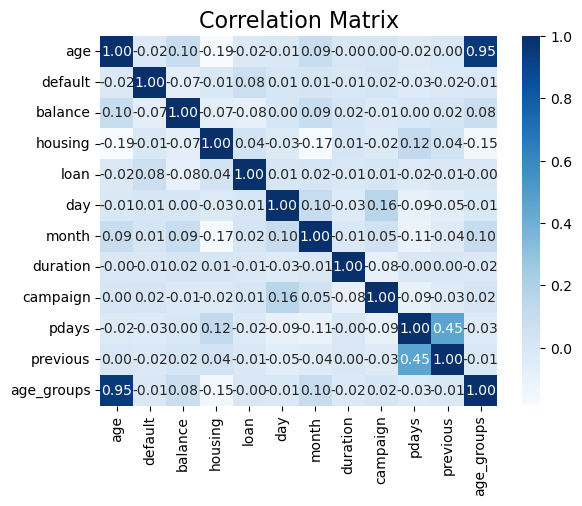

In [74]:
#### Check the Correlation Matrix of the Numerical Variables

numeric_bank_df = bank_df.select_dtypes(exclude="object")
# categorical_df = df.select_dtypes(include="object")

corr_numeric = numeric_bank_df.corr()


sns.heatmap(corr_numeric, cbar=True, cmap="Blues", annot=True, fmt=".2f")
plt.title("Correlation Matrix", fontsize=16,)
plt.show()  # very low correlation among the numeric variables, i.e. they all play important results

# print with numbers second decimal


In [60]:
cat_vars = ['job', 'marital', 'education', 'contact', 'poutcome']


bank_df_dummies = pd.get_dummies(bank_df, columns=cat_vars)

print("check the column names: ", bank_df_dummies.columns.tolist())
print("\n")
print("total number of columns: ", len(bank_df_dummies.columns.tolist()))


check the column names:  ['age', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'y', 'age_groups', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


total number of columns:  39


In [61]:
# Since Deposit is the label so we can now prepare the training and test data for further analysis

## Turn yes/no in deposit to 1/0

print(bank_df_dummies['y'].value_counts())


no     39922
yes     5289
Name: y, dtype: int64


In [62]:
bank_df_dummies['y'] = bank_df_dummies['y'].map(
    {'yes': 1, 'no': 0})

print(bank_df_dummies['y'].value_counts())


0    39922
1     5289
Name: y, dtype: int64


In [63]:
labels = bank_df_dummies[['y']]
print("check labels: ", labels.head(3))


check labels:     y
0  0
1  0
2  0


In [64]:
features = bank_df_dummies.drop(['y'], axis=1)


In [65]:
print("features data type: ", features.dtypes)


features data type:  age                    int64
default                int64
balance                int64
housing                int64
loan                   int64
day                    int64
month                  int64
duration               int64
campaign               int64
pdays                  int64
previous               int64
age_groups             int32
job_admin.             uint8
job_blue-collar        uint8
job_entrepreneur       uint8
job_housemaid          uint8
job_management         uint8
job_retired            uint8
job_self-employed      uint8
job_services           uint8
job_student            uint8
job_technician         uint8
job_unemployed         uint8
job_unknown            uint8
marital_divorced       uint8
marital_married        uint8
marital_single         uint8
education_primary      uint8
education_secondary    uint8
education_tertiary     uint8
education_unknown      uint8
contact_cellular       uint8
contact_telephone      uint8
contact_unknown       

In [66]:
col_names_list = list(features.columns.values)
print("features in a list: ", col_names_list)
print("\n")
print("number of features: ", len(col_names_list))


features in a list:  ['age', 'default', 'balance', 'housing', 'loan', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'age_groups', 'job_admin.', 'job_blue-collar', 'job_entrepreneur', 'job_housemaid', 'job_management', 'job_retired', 'job_self-employed', 'job_services', 'job_student', 'job_technician', 'job_unemployed', 'job_unknown', 'marital_divorced', 'marital_married', 'marital_single', 'education_primary', 'education_secondary', 'education_tertiary', 'education_unknown', 'contact_cellular', 'contact_telephone', 'contact_unknown', 'poutcome_failure', 'poutcome_other', 'poutcome_success', 'poutcome_unknown']


number of features:  38


In [67]:
X_train, X_test, y_train, y_test = train_test_split(
    features, labels, test_size=0.20, stratify=labels)

print("number of training samples: ", len(X_train))
print("number of test samples: ", len(y_test))


number of training samples:  36168
number of test samples:  9043


In [68]:
pipe_steps = [('scaler', StandardScaler()),
              ('decsT', DecisionTreeClassifier())]

check_params = {'decsT__criterion': ['gini', 'entropy'],
                'decsT__max_depth': np.arange(3, 15)}

pipeline = Pipeline(pipe_steps)
print(pipeline)


Pipeline(steps=[('scaler', StandardScaler()),
                ('decsT', DecisionTreeClassifier())])


In [15]:
# ### I love you so much

# from tqdm import tqdm_notebook as tqdm

# import warnings
# print("start fitting the data")
# warnings.filterwarnings("ignore")


# for cv in tqdm(range(3, 6)):
#     create_grid = GridSearchCV(pipeline, param_grid=check_params, cv=cv)
#     create_grid.fit(X_train, y_train)
#     print("score for %d fold CV := %3.2f" %(cv, create_grid.score(X_test, y_test)))
#     print("!!!! best fit parameters from GridSearchCV !!!!")
#     print(create_grid.best_params_)

# print("out o' the loop")


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.880407 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.880407 to fit



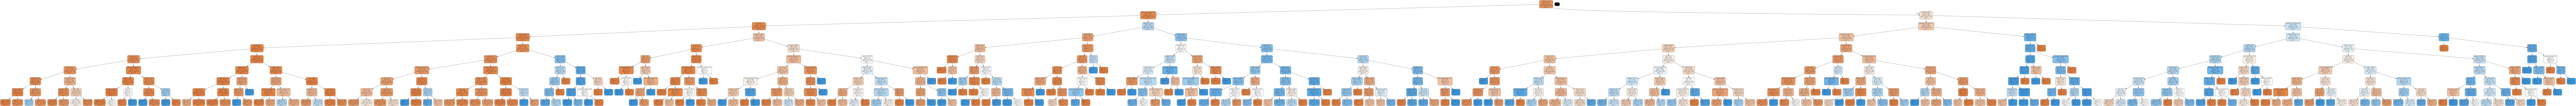

In [69]:

from six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus


DecsTree = DecisionTreeClassifier(criterion='gini', max_depth=9)
DecsTree.fit(X_train, y_train)


dot_data = StringIO()

export_graphviz(DecsTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=col_names_list, class_names=['0', '1'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('Bank_DecsT_after.png',)
# graph.set_size('"300, 180!"')
# graph.write_png('resized_tree.png')
Image(graph.create_png())


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.889706 to fit

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.889706 to fit



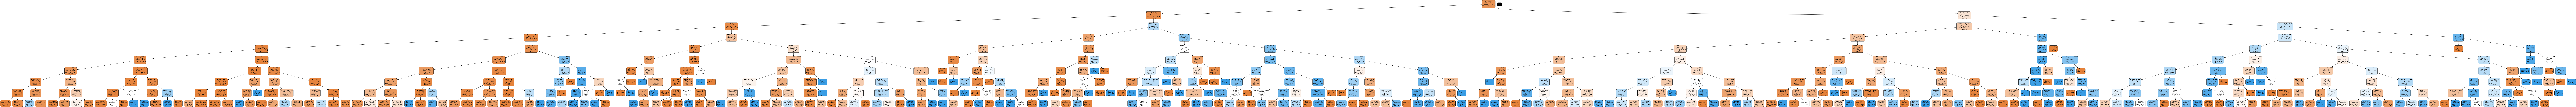

In [70]:
DecsTreeCheck = DecisionTreeClassifier(criterion='gini', max_depth=4)
DecsTree.fit(X_train, y_train)


dot_data = StringIO()

export_graphviz(DecsTree, out_file=dot_data,
                filled=True, rounded=True,
                special_characters=True, feature_names=col_names_list, class_names=['0', '1'])


graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

graph.write_png('Bank_DecsT_check_after.png',)
Image(graph.create_png())


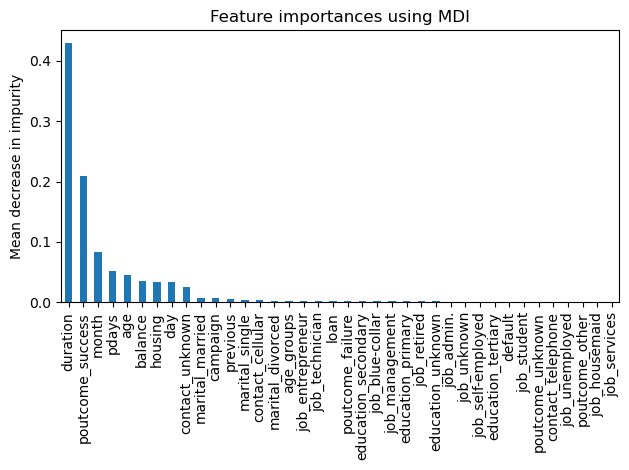

In [71]:
from pydoc import source_synopsis


importances = DecsTree.feature_importances_
forest_importances = pd.Series(importances, index=DecsTree.feature_names_in_)
forest_importances.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
